# IOD_pattern: zonal structure of boreal winter SST anomalies in the tropical Indian Ocean

Computes the zonal root mean square error (RMSE) of boreal spring (Sept) sea surface temperature anomalies (SSTA), calculating the patterns in the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N), used in the measurement of the Indian Ocean Dipole. Observations and model outputs are compared after processing, including smoothing with a 5-month triangular-weighted moving average.

## Datasets Used for SSTA Comparison
The following reference datasets are employed to evaluate the IOD-related SST patterns in model simulations:

- **TropFlux** (1979–2018): The primary dataset for comparison, providing high-quality estimates of surface fluxes and anomalies designed for tropical ocean and climate studies, combining in-situ measurements with satellite-derived data.
Additional datasets include:

- **20CRv2** (1871–2012): A century-scale reanalysis leveraging surface pressure observations to reconstruct global atmospheric conditions.- **ERA-Interim** (1979–2018): A widely used reanalysis dataset offering high-resolution estimates of atmospheric and surface variables with robust data assimilation techniques.
- **ERSSTv5** (1854–2018): A globally gridded dataset of historical SSTs derived from in-situ measurements and optimised for climate monitoring and iod studies.
- **HadISST** (1870–2018): A long-term SST and sea ice dataset combining ship and buoy observations with historical data reconstruction.
- **NCEP2** (1979–2018): The second-generation reanalysis dataset from NCEP, improving upon the earlier version for global atmospheric and oceanic variability analysis.

In [1]:
from esmvalcore.dataset import Dataset

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/myproxy/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').declare_namespace(__name__)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/pkg_resources/__init__.py:3117: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('logilab')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/pkg_resources/__init__.py:3117: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is pr

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim":  #kj13
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/esmvalcore/preprocessor/_io.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  calendar_index = int(


In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
# from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats


In [31]:
## pattern iode, iodw, eq
def sst_iode(cube):
    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land") #shp or land fraction
# detrend?
    cube_east = extract_region(cube, **iod_east)
    cube_east = rolling_window_statistics(cube_east, coordinate='time', operator='mean', window_length=5)
    cube_east = rolling_window_statistics(cube_east, coordinate='time', operator='mean', window_length=5)
    cube_east = area_statistics(cube_east,operator='mean')
    cube_east = extract_month(cube_east,9) # get Sep
    #remove time mean
    cube_east = anomalies(cube_east,period='monthly')

    return cube_east

def sst_iodw(cube):
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    
    cube = convert_units(cube, units="degC")

    cube_west = extract_region(cube, **iod_west)
    cube_west = rolling_window_statistics(cube_west, coordinate='time', operator='mean', window_length=5)
    cube_west = rolling_window_statistics(cube_west, coordinate='time', operator='mean', window_length=5)
    cube_west = area_statistics(cube_west,operator='mean')
    cube_west = extract_month(cube_west,9) # get Sep
    #remove time mean
    cube_west = anomalies(cube_west,period='monthly')
    return cube_west

def sst_eq(cube):
    region = {"start_longitude": 40., "end_longitude": 120., "start_latitude": -15., "end_latitude": 15.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube = extract_region(cube, **region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube,9) # get Sep
# remove time mean
    cube = anomalies(cube, period='monthly')
    cube = meridional_statistics(cube, 'mean')

    return cube

#linear regression of sst_iod on sst_eq
def lin_regress(cube_ssta, cube_iod): #1d 
    slope_ls = []
    for lon_slice in cube_ssta.slices(['time']): # iterate over 120 lon points
        res = scipy.stats.linregress(cube_iod.data, lon_slice.data)
        # res = scipy.stats.linregress(lon_slice.data, cube_iod.data)
        slope_ls.append(res[0])

    return cube_ssta.coord('longitude').points, slope_ls

# rmse = np.sqrt(np.mean((obs_regressed - model_regressed) ** 2))

In [32]:
def sst_eq2(cube):
    region = {"start_longitude": 40., "end_longitude": 120., "start_latitude": -15., "end_latitude": 15.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")

    cube = extract_region(cube, **region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube,9) # get Sep

    cube = anomalies(cube, period='monthly')
    return cube
    
# iterate over lat/lon for 2d
def lin_regress_2(cube_ssta, cube_iod): # cube_ssta(no meridional_statistics)
    slope_ls = []
    ## flatten and reshape
    for lonlat_slice in cube_ssta.slices(['time']):
        res = scipy.stats.linregress(cube_iod.data, lonlat_slice.data)
        slope_ls.append(res[0])
    
    slope_array = np.array(slope_ls)
    ssta_reg = slope_array.reshape(cube_ssta.shape[1],cube_ssta.shape[2])
    cube = iris.cube.Cube(ssta_reg, long_name='regression iod SSTA',
                          dim_coords_and_dims=[(cube_ssta.coord('latitude'),0),
                                               (cube_ssta.coord('longitude'),1)])

    return cube

In [33]:
model_datasets_prep1_east = {name: sst_iode(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep1_west = {name: sst_iodw(dataset) for name, dataset in model_datasets.items()}

model_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep3 = {name: sst_eq2(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1_east = {name: sst_iode(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep1_west = {name: sst_iodw(dataset) for name, dataset in obs_datasets.items()}

obs_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep3 = {name: sst_eq2(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

# Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the main differences between the model and the reference.

Text(0.5, 0.95, 'RMSE: 0.33 ')

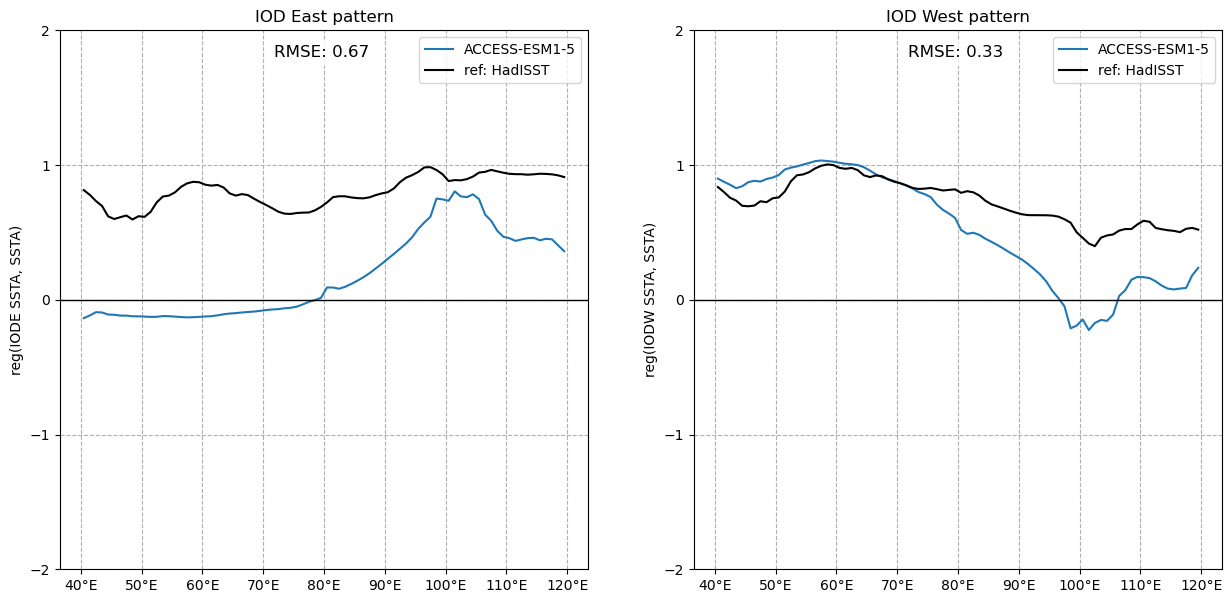

In [34]:
## linear regression sst_eq on sst_iod

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

fig = plt.figure(figsize=(15, 7))

reg_mod_east = lin_regress(model_datasets_prep2["ACCESS-ESM1-5"], model_datasets_prep1_east["ACCESS-ESM1-5"])
reg_mod_west = lin_regress(model_datasets_prep2["ACCESS-ESM1-5"], model_datasets_prep1_west["ACCESS-ESM1-5"])

ax1 = plt.subplot(121)

# return slope data to longitude - array?
ax1.plot(reg_mod_east[0], reg_mod_east[1], label="ACCESS-ESM1-5") #units

ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

reg_east = lin_regress(obs_datasets_prep2["HadISST"], obs_datasets_prep1_east["HadISST"])
ax1.plot(reg_east[0],reg_east[1], color='black',label='ref: HadISST')

ax1.set_yticks(np.arange(-2,3, step=1))
ax1.axhline(y=0, color='black', linewidth=1)
ax1.set_ylabel("reg(IODE SSTA, SSTA)")
ax1.set_title('IOD East pattern') #
ax1.legend()
ax1.grid(linestyle='--')

rmse_east = np.sqrt(np.mean((np.array(reg_east[1]) - np.array(reg_mod_east[1])) ** 2)) #metric

ax1.text(0.5, 0.95, f"RMSE: {rmse_east:.2f} ", fontsize=12, ha='center', transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax2 = plt.subplot(122)

# return slope data to longitude - array?
ax2.plot(reg_mod_west[0], reg_mod_west[1], label="ACCESS-ESM1-5") #units

ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

reg_west = lin_regress(obs_datasets_prep2["HadISST"], obs_datasets_prep1_west["HadISST"])
ax2.plot(reg_west[0],reg_west[1], color='black',label='ref: HadISST')

ax2.set_yticks(np.arange(-2,3, step=1))
ax2.axhline(y=0, color='black', linewidth=1)
ax2.set_ylabel("reg(IODW SSTA, SSTA)")
ax2.set_title('IOD West pattern') #
ax2.legend()
ax2.grid(linestyle='--')

rmse_west = np.sqrt(np.mean((np.array(reg_west[1]) - np.array(reg_mod_west[1])) ** 2)) #metric

ax2.text(0.5, 0.95, f"RMSE: {rmse_west:.2f} ", fontsize=12, ha='center', transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

**Figure 1**: Zonal structure of sea surface temperature anomalies (SSTA) in the southeastern Indian Ocean (averaged between 90-110E, 10°S and 10°N) and western Indian Ocean (averaged between 50-70E, 10S-0). The figure highlights the zonal distribution of SSTA associated with IODE and IODW SSTAs. The black curve represents the reference data, while the blue curve corresponds to the model output. The derived metric is the zonal root mean square error (RMSE) between the model and reference curves.

## Diagnostic Level 2

The second level shows the broader picture to better understand the spatial pattern of the IOD: the map of the anomalies in the equatorial Indian Ocean.


In [35]:
reg2_mod_east = lin_regress_2(model_datasets_prep3["ACCESS-ESM1-5"], model_datasets_prep1_east["ACCESS-ESM1-5"])
reg2_mod_west = lin_regress_2(model_datasets_prep3["ACCESS-ESM1-5"], model_datasets_prep1_west["ACCESS-ESM1-5"])

reg2_obs_east = lin_regress_2(obs_datasets_prep3["HadISST"], obs_datasets_prep1_east["HadISST"])
reg2_obs_west = lin_regress_2(obs_datasets_prep3["HadISST"], obs_datasets_prep1_west["HadISST"])

#make dict process
process_east = {"ACCESS-ESM1-5 IODE":reg2_mod_east , "HadISST IODE":reg2_obs_east} 
process_west = {"ACCESS-ESM1-5 IODW":reg2_mod_west , "HadISST IODW":reg2_obs_west} 


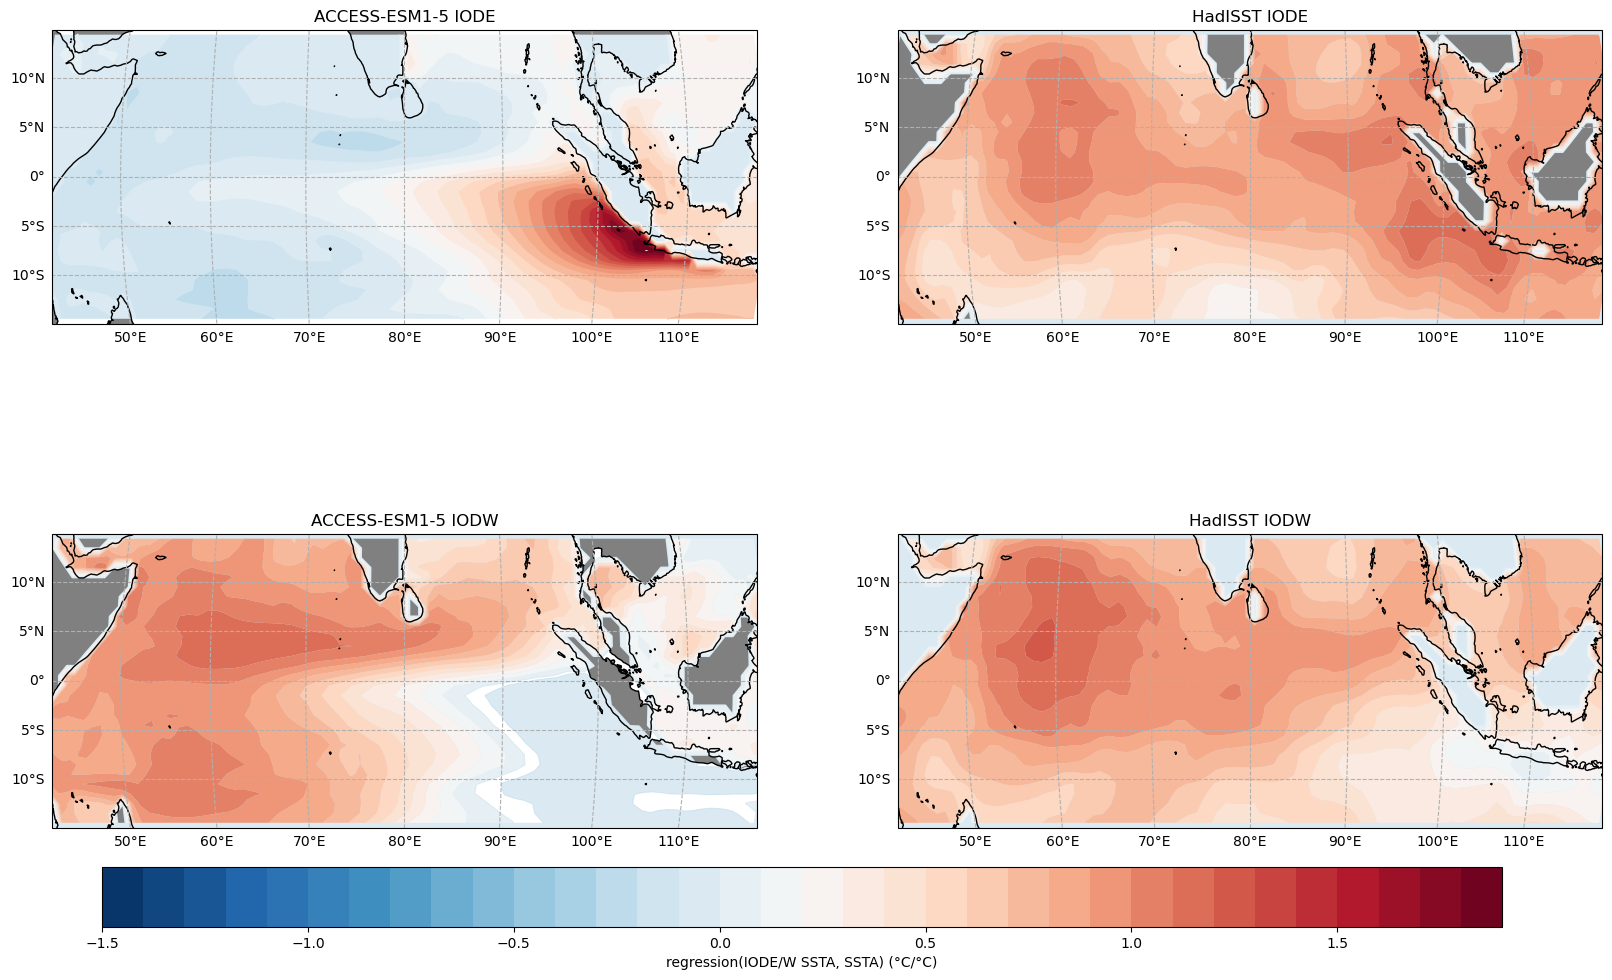

In [36]:
# 
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 12))
proj = ccrs.Orthographic(central_longitude=80.0)

#IOD EAST
i =221
# process = {**model_datasets_prep3, **obs_datasets_prep3}


for label, cube in process_east.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-1.5,2,0.1), cmap='RdBu_r')
    # cf1 = plt.contourf(reg2[0],reg2[1],reg2[2], cmap='RdBu_r', levels=np.arange(0,2,0.1))

    ax1.set_extent([40, 120, -15, 15], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom

#IOD WEST
i =223
# process = {**model_datasets_prep3, **obs_datasets_prep3}


for label, cube in process_west.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-1.5,2,0.1), cmap='RdBu_r')
    # cf1 = plt.contourf(reg2[0],reg2[1],reg2[2], cmap='RdBu_r', levels=np.arange(0,2,0.1))

    ax1.set_extent([40, 120, -15, 15], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-2,2.5,0.5))
cbar.set_label('regression(IODE/W SSTA, SSTA) (°C/°C)')

Figure 2: sea surface temperature anomalies (SSTA) associated with the IODE and IODW regions in the equatorial Indian Ocean, showing .... The left and right maps show respectively the reference and the model.